## This script demonstrates the process of generating kappa and gamma values from both halo and GLASS data sources, and how to visualize the joint distribution of the total kappa and gamma values.

First, we import necessary modules and classes from `sim_pipeline.halos.halos_plus_glass` and `astropy.cosmology`. We also define our cosmology model using `FlatLambdaCDM` with parameters `H0=70` and `Om0=0.3`.
Next, we read the glass data from the file `"z5data.npy"` using the `read_glass_data` function. It returns the kappa values, gamma values, and nside. Then, we calculate the sky area using `skyarea_form_n` function with the `nside`.

In [8]:
# TODO: make it more realistic including:                                                                                           1. use z5data.npy(~780MB) and make n from generate_samples_from_glass.() equal a higher number.                                  2. In generate_meanzero_halos_multiple_times(n_times=5, skypy_config=None, skyarea=0.0001, cosmo=cosmo, samples_number_for_one_halos=1000, renders_numbers=200) let skyarea=skyarea, n_times larger.                                      3. For lower halo mass min? (now 5*10^11)
from slsim.Halos.halos_plus_glass import read_glass_data,skyarea_form_n,generate_samples_from_glass,halos_plus_glass
import os

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
print(parent_directory)
file_path = os.path.join(parent_directory, 'data/glass/sampled_z4.9data.npy')
kappa_values, gamma_values, nside = read_glass_data(file_name=file_path)
skyarea = skyarea_form_n(nside)
kappa_random_glass, gamma_random_glass = generate_samples_from_glass(kappa_values, gamma_values, n=5000)
print(kappa_random_glass.shape)

/Users/tz/Documents/GitHub/slsim
(5000,)


### After that, we generate kappa and gamma values from halos using `run_halos_without_kde` or `run_halos_without_kde_by_multiprocessing` function. These functions repeat the generation of halos `n_iterations` times and accumulates the results.
##### For `n_iterations` is large (>10), using ` run_halos_without_kde_by_multiprocessing` will be faster.
###### for example, for `n_iterations=25, sky_area=0.0001, samples_number=200,cosmo=cosmo,                                                              m_min=None, m_max=None, z_max=None` :
        `run_halos_without_kde_by_multiprocessing` takes ~ 50 secs
        `run_halos_without_kde` takes ~ 200 secs


In [12]:
from slsim.Halos.halos_plus_glass import run_halos_without_kde_by_multiprocessing
import numpy as np


#nk,ng = run_halos_without_kde(n_iterations=25, sky_area=0.0001, samples_number=200,cosmo=cosmo,                                                              m_min=None, m_max=None, z_max=None)

nk,ng = run_halos_without_kde_by_multiprocessing(n_iterations=50, sky_area=0.00082, samples_number=100,cosmo=cosmo,                                                              m_min=1e12, m_max=1e14, z_max=5.0)

mean_kappa = np.mean(nk)
kappa_random_halos, gamma_random_halos = nk - mean_kappa,ng

/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 50 halo-lists took 7.070033311843872 seconds to run


The total kappa and gamma values are then calculated by combining the values from halo and glass data sources. This is done by the `halos_plus_glass` function.

In [13]:
total_kappa, total_gamma = halos_plus_glass(kappa_random_glass, gamma_random_glass, kappa_random_halos, gamma_random_halos)

Finally, we visualize the joint distribution of the total kappa and gamma values using a hexbin plot.
We also fit a Gaussian KDE to the joint distribution of kappa and gamma values and generate a random sample from this distribution.
The joint distribution of the resampled kappa and gamma values is also visualized using a hexbin plot.

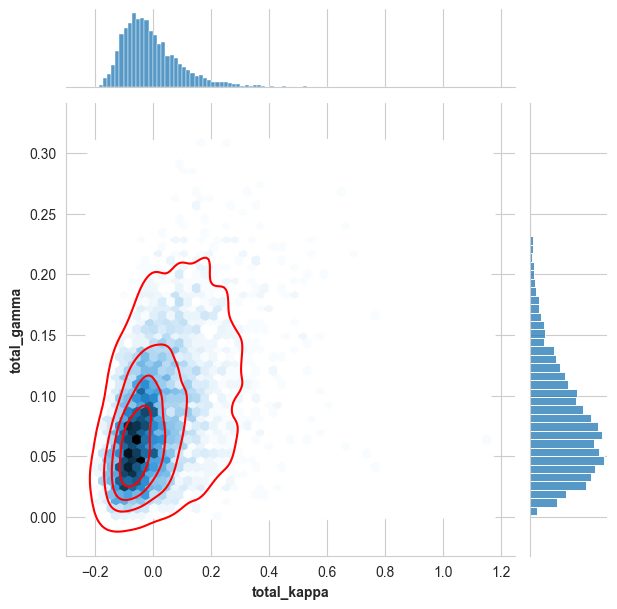

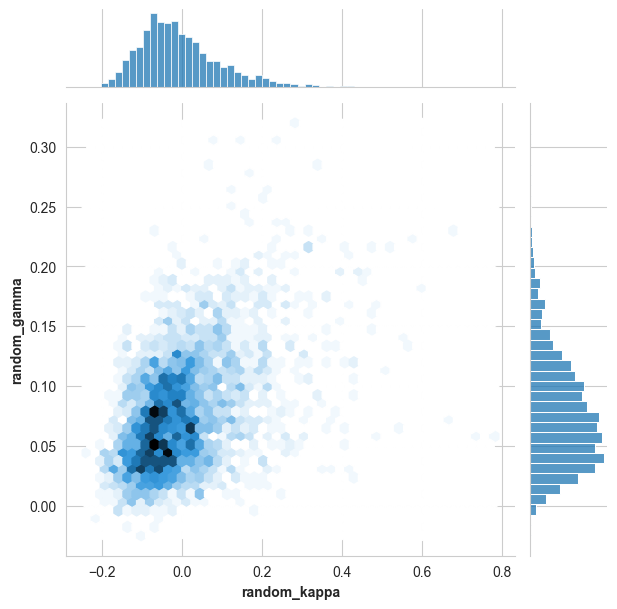

In [11]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

total_plot = sns.jointplot(x=total_kappa, y=total_gamma,kind='hex')
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel('total_kappa', fontweight='bold')
total_plot.ax_joint.set_ylabel('total_gamma', fontweight='bold')
plt.show()

# Use Gaussian KDE to fit the joint distribution
kernel = stats.gaussian_kde(np.vstack([total_kappa, total_gamma]))
n = 3000  # Number of random numbers to generate
kappa_random, gamma_random = kernel.resample(n)
modified_plot = sns.jointplot(x=kappa_random, y=gamma_random, kind='hex')
modified_plot.ax_joint.set_xlabel('random_kappa', fontweight='bold')
modified_plot.ax_joint.set_ylabel('random_gamma', fontweight='bold')
plt.show()
# TODO: make gamma render by KDE >0

In [ ]:

import numpy as np
import os
from slsim.Halos.halos_plus_glass import read_glass_data, skyarea_form_n, generate_samples_from_glass, halos_plus_glass, run_certain_redshift_lensext_kde_by_multiprocessing
from astropy.cosmology import default_cosmology


def calculate_joint_distributions(zs_range, zd_range, base_file_path, nside=2048, n_iterations=500, samples_number=20, m_min='1E+12', m_max='1E+16'):

    
    cosmo = default_cosmology.get()
    
    joint_distributions = {}


    for zs in zs_range:
        for zd in zd_range:
            if zd < zs:  
                file_path = os.path.join(base_file_path,f'sampled_z{zs:.1f}data.npy')

                kappa_values, gamma_values, _ = read_glass_data(file_name=file_path)
                skyarea = skyarea_form_n(nside)
                kappa_random_glass, gamma_random_glass = generate_samples_from_glass(kappa_values, gamma_values, n=1000)

                distribution = run_certain_redshift_lensext_kde_by_multiprocessing(
                    n_iterations=n_iterations, sky_area=skyarea, samples_number=samples_number, 
                    cosmo=cosmo, m_min=m_min, m_max=m_max, z_max=zs, zs=zs, zd=zd, 
                    mass_sheet_correction=False, listmean=False
                )

                nk1 = [point[0] for point in distribution]
                ng1 = [point[1] for point in distribution]
                nk1_mean = sum(nk1) / len(nk1)
                nk1 = [item - nk1_mean for item in nk1]

                total_kappa, total_gamma = halos_plus_glass(kappa_random_glass, gamma_random_glass, nk1, ng1)

                joint_distributions[(zs, zd)] = (total_kappa, total_gamma)

    return joint_distributions

base_file_path = '/Users/tz/Documents/GitHub/slsim/data/glass'  

zs_range = np.arange(0.1, 5.0, 0.1)
zd_range = np.arange(0.1, 5.0, 0.1)  

joint_distributions = calculate_joint_distributions(zs_range, zd_range, base_file_path)


In [ ]:
import numpy as np
import os
import h5py
from slsim.Halos.halos_plus_glass import read_glass_data, skyarea_form_n, generate_samples_from_glass, halos_plus_glass, run_certain_redshift_lensext_kde_by_multiprocessing
from astropy.cosmology import default_cosmology

def calculate_joint_distributions(zs_range, zd_range, base_file_path, n_iterations=500, samples_number=20, m_min=1e12, m_max=1e16):
    cosmo = default_cosmology.get()
    joint_distributions = {}

    for zs in zs_range:
        for zd in zd_range:
            if zd < zs:  
                file_path = os.path.join(base_file_path, f'sampled_z{zs:.1f}data.npy')

                kappa_values, gamma_values, _ = read_glass_data(file_name=file_path)
                kappa_random_glass, gamma_random_glass = generate_samples_from_glass(kappa_values, gamma_values, n=1000)

                distribution = run_certain_redshift_lensext_kde_by_multiprocessing(
                    n_iterations=n_iterations, sky_area=0.00082, samples_number=samples_number, 
                    cosmo=cosmo, m_min=m_min, m_max=m_max, z_max=zs, zs=zs, zd=zd, 
                    mass_sheet_correction=False, listmean=False
                )

                nk1 = [point[0] for point in distribution]
                ng1 = [point[1] for point in distribution]
                nk1_mean = sum(nk1) / len(nk1)
                nk1 = [item - nk1_mean for item in nk1]

                total_kappa, total_gamma = halos_plus_glass(kappa_random_glass, gamma_random_glass, nk1, ng1)

                kappa_gamma_pairs = np.column_stack((total_kappa, total_gamma))
                joint_distributions[(zs, zd)] = kappa_gamma_pairs

    with h5py.File(os.path.join(base_file_path, 'joint_distributions.h5'), 'w') as f:
        for (zs, zd), kappa_gamma in joint_distributions.items():
            f.create_dataset(f'zs_{zs}_zd_{zd}', data=kappa_gamma)

    return joint_distributions

base_file_path = '/Users/tz/Documents/GitHub/slsim/data/glass'
zs_range = np.arange(0.1, 5.0, 0.1)
zd_range = np.arange(0.1, 5.0, 0.1)
joint_distributions = calculate_joint_distributions(zs_range, zd_range, base_file_path)

In [18]:
import h5py
import numpy as np

def extract_distributions(input_file_path, output_file_path, zd_target=0.0, zs_min=0.1, zs_max=4.9):
    """
    Extracts distributions from an H5 file with specific zd and zs range and saves them to a new H5 file.

    Parameters:
    input_file_path (str): Path to the input H5 file.
    output_file_path (str): Path to the output H5 file.
    zd_target (float): The target lens redshift (zd) to filter.
    zs_min (float): The minimum source redshift (zs) to include.
    zs_max (float): The maximum source redshift (zs) to include.
    """
    with h5py.File(input_file_path, 'r') as input_file, h5py.File(output_file_path, 'w') as output_file:
        for dataset_name in input_file:
            # Extract zs and zd from the dataset name
            _, zs_str, _, zd_str = dataset_name.split('_')
            zs, zd = float(zs_str), float(zd_str)

            # Check if zd and zs are within the specified range
            if zd == zd_target and zs_min <= zs <= zs_max:
                data = input_file[dataset_name][()]
                output_file.create_dataset(dataset_name, data=data)

input_file_path = '/Users/tz/Documents/GitHub/slsim/data/glass/joint_distributions.h5'
output_file_path = '/Users/tz/Documents/GitHub/slsim/data/glass/kg_distributions_nolos.h5' 
extract_distributions(input_file_path, output_file_path)



In [11]:
import numpy as np
import os
import h5py
from slsim.Halos.halos_plus_glass import read_glass_data, skyarea_form_n, generate_samples_from_glass, halos_plus_glass, run_certain_redshift_lensext_kde_by_multiprocessing, run_halos_without_kde_by_multiprocessing
from astropy.cosmology import default_cosmology
    
def calculate_no_los_distributions(zs_range, base_file_path, n_iterations=500, samples_number=20, m_min=1e12, m_max=1e16):
    cosmo = default_cosmology.get()
    joint_distributions = {}

    for zs in zs_range:
                file_path = os.path.join(base_file_path, f'sampled_z{zs:.1f}data.npy')
                
                kappa_values, gamma_values, _ = read_glass_data(file_name=file_path)
                kappa_random_glass, gamma_random_glass = generate_samples_from_glass(kappa_values, gamma_values, n=1000)
                
                distribution=run_halos_without_kde_by_multiprocessing(
                    n_iterations=n_iterations,
                    sky_area=0.00082,
                    samples_number=samples_number,
                    cosmo=cosmo,
                    m_min=m_min,
                    m_max=m_max,
                    z_max=zs,
                    mass_sheet_correction=False,
                    listmean=False,)
                
                nk1 =  distribution[0]
                ng1 = distribution[1]
                nk1_mean = sum(nk1) / len(nk1)
                nk1 = [item - nk1_mean for item in nk1]

                total_kappa, total_gamma = halos_plus_glass(kappa_random_glass, gamma_random_glass, nk1, ng1)

                kappa_gamma_pairs = np.column_stack((total_kappa, total_gamma))
                joint_distributions[zs] = kappa_gamma_pairs

    with h5py.File(os.path.join(base_file_path, 'no_nonlinear_distributions.h5'), 'w') as f:
        for zs, kappa_gamma in joint_distributions.items():
            f.create_dataset(f'zs_{zs}', data=kappa_gamma)
    
    return joint_distributions

base_file_path = '/Users/tz/Documents/GitHub/slsim/data/glass'
zs_range = np.arange(0.1, 5.0, 0.1)
joint_distributions2 = calculate_no_los_distributions(zs_range, base_file_path)

/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 5.6966400146484375 seconds to run


/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range


The 500 halo-lists took 5.658358097076416 seconds to run


/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/pyt

The 500 halo-lists took 5.71924901008606 seconds to run


/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range


The 500 halo-lists took 5.861316204071045 seconds to run


/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/dec

The 500 halo-lists took 5.875501871109009 seconds to run


/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range


The 500 halo-lists took 6.0882408618927 seconds to run


/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/slsim/Halos/halos.py:312: UserWarning: No Halos found in the given redshift range
  warnings.warn("No Halos found in the given redshift range")
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/dec

The 500 halo-lists took 6.144258975982666 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 6.363227844238281 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 6.596089839935303 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 6.81892991065979 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 6.981871843338013 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 7.227373123168945 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 7.368058204650879 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 7.559407711029053 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 7.8251190185546875 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 7.9481728076934814 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 8.239804744720459 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 8.429538011550903 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 8.516326189041138 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 8.756823062896729 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 8.98721194267273 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 9.186259031295776 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 9.503998041152954 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 9.636730194091797 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 9.78097915649414 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 9.926894903182983 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.120447874069214 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.100614786148071 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.21981430053711 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.402112007141113 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.383824825286865 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.450496196746826 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.584748983383179 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.573430061340332 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 11.461999893188477 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 11.118499279022217 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 11.00393795967102 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.885828256607056 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 11.028698682785034 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.937247037887573 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.719161033630371 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.819518804550171 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.606347560882568 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.874377012252808 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.925052881240845 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 11.111209869384766 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.986963987350464 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 11.013358116149902 seconds to run


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 500 halo-lists took 10.910195112228394 seconds to run
